<a href="https://colab.research.google.com/github/yingzibu/MOL2AE/blob/main/examples/ADME_T_SO_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet

! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

In [2]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, average_precision_score

import math

def get_preds(threshold, probabilities):
    try:
        if probabilities.shape[1] == 2: probabilities = probabilities[:, 1]
    except: pass
    return [1 if prob > threshold else 0 for prob in probabilities]

def evaluate_model(TP, FP, TN, FN):

    ACCURACY = (TP + TN) / (TP+FP+TN+FN)
    SE = TP/(TP+FN)
    recall = SE
    SP = TN/(TN+FP)
    weighted_accuracy = (SE + SP) / 2

    precision = TP / (TP + FP)
    SP = TN/(TN+FP)
    F1 = 2 * precision * recall /(precision + recall)

    temp = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
    if temp != 0:
        MCC = (TP*TN-FP*FN)*1.0/(math.sqrt(temp))
    else:
        print('equation for MCC is (TP*TN-FP*FN)*1.0/(math.sqrt(temp))')
        print('TP, FP, TN, FN', TP, FP, TN, FN)
        print('temp=0')
        MCC = 'N/A'

    return ACCURACY,SE, SP, weighted_accuracy, precision, F1, MCC

def evaluate(y_real, y_hat, y_prob):
    TN, FP, FN, TP = confusion_matrix(y_real, y_hat).ravel()
    ACCURACY,SE, SP, weighted_accuracy, precision, F1, \
        MCC  = evaluate_model(TP, FP, TN, FN)
    try:
        if y_prob.shape[1] == 2: proba = y_prob[:, 1]
        else: proba = y_prob
    except: proba = y_prob
    AP = average_precision_score(y_real, proba)
    AUC = roc_auc_score(y_real, proba)
    print('Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP')
    if MCC != 'N/A':
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC),
      "&%8.3f" % (MCC), "&%8.3f" % (AP))
    else:
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC), "& ",
        MCC, "&%8.3f" % (AP))

    return ACCURACY, weighted_accuracy, precision, SE, SP, F1, AUC, MCC, AP

In [3]:
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
import pandas as pd
import numpy as np
from tqdm import tqdm
"Reference: https://github.com/Yimeng-Wang/JAK-MTATFP/blob/main/preprocess.py"

from molvs.normalize import Normalizer, Normalization
from molvs.charge import Reionizer, Uncharger
import torch.nn as nn

from tdc.single_pred import ADME
from rdkit import RDLogger
import warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")
MASK = -100


def preprocess(smi):
    mol = Chem.MolFromSmiles(smi)
    normalizer = Normalizer()
    new1 = normalizer.normalize(mol)
    remover = SaltRemover()
    new2 = remover(new1)
    neutralize1 = Reionizer()
    new3 = neutralize1(new2)
    neutralize2 = Uncharger()
    new4 = neutralize2(new3)
    new_smiles = Chem.MolToSmiles(new4, kekuleSmiles=False)
    return new_smiles

In [4]:
def rename_cols(df, name): return df.rename(columns={'Y':name})

def clean_mol(df:pd.DataFrame):
    prev_len = len(df)
    for i in tqdm(range(len(df)), total=len(df), desc='Cleaning mols'):
        try: df.iloc[i]['Drug'] = preprocess(df.iloc[i]['Drug'])
        except: df.drop(i)
    if len(df) != prev_len: print(f'prev len: {prev_len}; after clean: {len(df)}')
    return df.reset_index(drop=True)

def scal(df): # min max scaling
    # df_norm = df.loc[:, df.columns!='Drug'].copy()
    df_norm = df.copy()
    for col in df_norm.columns:
        if col == 'Drug': pass
        else:
            df_norm[col] = (df_norm[col]-df_norm[col].min()
                )/(df_norm[col].max()-df_norm[col].min()) * 10
    # df_norm['Drug'] = df['Drug']
    return df_norm

In [5]:

import pandas as pd

import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset

def collate_molgraphs(data):
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
        # masks = (labels == MASK).long()
    return smiles, bg, labels, masks

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [6]:
import time
def get_graph_dataset(df, name):
    atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
    bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
    n_feats_num = atom_featurizer.feat_size('hv')
    e_feats_num = bond_featurizer.feat_size('he')

    # named_tuple =  # get struct_time
    time_string = time.strftime("%m_%d_%Y_%H:%M:%S", time.localtime())

    params = {'node_featurizer': atom_featurizer,
            'edge_featurizer': bond_featurizer,
            'smiles_column': 'Drug',
            'cache_file_path': time_string+'.bin',
            'task_names': name, 'load': True, 'n_jobs': len(name)}
    graph_dataset = MoleculeCSVDataset(df, **params)
    return graph_dataset


cuda = torch.cuda.is_available()
if cuda: device = 'cuda'
else: device = 'cpu'
n_layers = 3
dropout = 0.5

# model = model_zoo.AttentiveFPPredictor(
#             node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
#             num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
#             n_tasks=len(names), dropout=dropout).to(device)

import sklearn.metrics as metrics


def reg_evaluate(label_clean, preds_clean):
    mae = metrics.mean_absolute_error(label_clean, preds_clean)
    mse = metrics.mean_squared_error(label_clean, preds_clean)
    rmse = np.sqrt(mse) #mse**(0.5)
    r2 = metrics.r2_score(label_clean, preds_clean)

    # print("Overall results of sklearn.metrics:")
    print("MAE:",mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)

    eval_result_r2 =   f'R2:     {r2:.3f}'
    eval_result_mae =  f'MAE:   {mae:.3f}'
    eval_result_rmse = f'RMSE: {rmse:.3f}'

    return eval_result_r2, eval_result_mae, eval_result_rmse

In [7]:
import torch.nn.functional as F
from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

def train_epoch(epoch, model, data_loader, loss_func, optimizer):
    model.train()
    losses = 0
    train_meter = Meter()
    for batch_id, batch_data in enumerate(data_loader):
        smiles, bg, labels, masks = batch_data
        bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
        n_feats = bg.ndata.pop('hv').to(device)
        e_feats = bg.edata.pop('he').to(device)

        pred = model(bg, n_feats, e_feats)
        mask = masks < 1
        loss = loss_func(pred[~mask], labels[~mask])
        del mask
        # loss = (loss_func(pred, labels)*(masks!=0).float()).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter.update(pred, labels, masks)
        del pred
        del labels
        del masks
        losses += loss.item()
        # losses.append(loss.item())

    total_r2 = np.mean(train_meter.compute_metric('r2'))
    total_loss = losses / len(data_loader.dataset)
    # if epoch % 10 == 0 and epoch != 0:
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: [Train] R2: {total_r2:.3f}, Loss: {total_loss:.3f}')

    return total_r2, total_loss


def eval_epoch(model, data_loader, loss_func):
    model.eval()
    val_losses = 0
    eval_meter = Meter()
    with torch.no_grad():
        for batch_data in data_loader:
            smiles, bg, labels, masks = batch_data
            bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
            n_feats = bg.ndata.pop('hv').to(device)
            e_feats = bg.edata.pop('he').to(device)
            val_pred = model(bg, n_feats, e_feats)
            mask = masks < 1
            val_loss = loss_func(val_pred[~mask], labels[~mask])
            # val_loss = (loss_func(val_pred, labels)*(masks!=0).float()).mean()
            # val_losses.append(val_loss.item())
            val_losses += val_loss.item()
            eval_meter.update(val_pred, labels, masks)
            del val_pred
            del labels
            del masks
            del n_feats
            del e_feats
        total_score = np.mean(eval_meter.compute_metric('r2'))
        total_loss = val_losses / len(data_loader.dataset)
        # print(f'[Valid] R2: {total_score:.3f}, Loss: {total_loss:.3f}')
    return total_score, total_loss

from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('herg_central')

def single_train(names, IS_R, SCALE=False, early_stop=30):
    for i, name in enumerate(names):
        print('*'*15, name, '*'*15)
        if name in label_list:
            data = Tox(name='herg_central', label_name=name)
        else: data = Tox(name=name)
        # data = ADME(name=name)
        data.label_distribution()

        split = data.get_split()
        train, valid = clean_mol(split['train']), clean_mol(split['valid'])
        test =  clean_mol(split['test'])

        train = rename_cols(train[['Drug', 'Y']], name)
        valid = rename_cols(valid[['Drug', 'Y']], name)
        test  = rename_cols(test[['Drug', 'Y']],  name)

        if IS_R and SCALE: train, valid, test = scal(train), scal(valid), scal(test)

        if i == 0: trains, valids, tests = train, valid, test
        else:
            trains = trains.merge(train, how='outer')
            valids = valids.merge(valid, how='outer')
            tests = tests.merge(test, how='outer')


    atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
    bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
    n_feats_num = atom_featurizer.feat_size('hv')
    e_feats_num = bond_featurizer.feat_size('he')

    import time
    named_tuple = time.localtime() # get struct_time
    time_string = time.strftime("%m_%d_%Y_%H:%M:%S", named_tuple)

    params = {'node_featurizer': atom_featurizer,
            'edge_featurizer': bond_featurizer,
            'smiles_column': 'Drug',
            #   'cache_file_path': time_string+'.bin',
            'task_names': names, 'load': True, 'n_jobs': len(names)}


    train_datasets = MoleculeCSVDataset(trains, cache_file_path=f'train_{time_string}.bin', **params)
    valid_datasets = MoleculeCSVDataset(valids,cache_file_path=f'valid_{time_string}.bin', **params)
    test_datasets = MoleculeCSVDataset(tests, cache_file_path=f'test_{time_string}.bin', **params)

    batch_size = 64
    loader_params ={'batch_size': batch_size,
                    'shuffle': True,
                    'collate_fn': collate_molgraphs}

    train_loader = DataLoader(train_datasets, **loader_params)
    valid_loader = DataLoader(valid_datasets, **loader_params)
    test_loader  = DataLoader(test_datasets,  **loader_params)

    cuda = torch.cuda.is_available()
    if cuda: device = 'cuda'
    else: device = 'cpu'
    n_layers = 3
    dropout = 0.5
    if IS_R: loss_fn = nn.MSELoss(reduction='sum') # if regression
    else: loss_fn = nn.BCEWithLogitsLoss(reduction='sum') # if classification

    model = model_zoo.AttentiveFPPredictor(
                node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
                num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
                n_tasks=len(names), dropout=dropout).to(device)


    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
    stopper = EarlyStopping(mode='lower', patience=early_stop)
    n_epochs = 1000
    best_epoch = 0
    min_loss = 100000

    # if best_epoch != 0:
    #     model.load_state_dict(torch.load('ckpt_e.pt', map_location=device))

    for epoch in range(best_epoch, best_epoch + n_epochs):
        score = train_epoch(epoch, model, train_loader, loss_fn, optimizer)
        val_score = eval_epoch(model, valid_loader, loss_fn)
        early_stop = stopper.step(val_score[1], model)
        if val_score[1] < min_loss and epoch > 3:
            # print(f'prev min loss {min_loss:.3f}, now better loss {val_score[1]:.3f}')
            min_loss = val_score[1]
            torch.save(model.state_dict(), 'ckpt_e.pt')
            # print(f'save model at epoch: {epoch}')
            best_epoch = epoch

        if early_stop: print('early stop'); break


    model = model_zoo.AttentiveFPPredictor(
                node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
                num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
                n_tasks=len(names)).to(device)

    model.load_state_dict(torch.load('ckpt_e.pt', map_location=device))

    print('Evaluate on test sets')
    model = model.cpu()
    model.eval()
    total_loss = 0
    test_meter = Meter()
    if IS_R: print('using MSELoss')
    else: print('using BCELOSSwithdigits')

    for i, batch_data in tqdm(enumerate(test_loader), total=len(test_loader)):
        smiles, bg, labels, masks = batch_data

        n_feats = bg.ndata.pop('hv')
        e_feats = bg.edata.pop('he')

        pred = model(bg, n_feats, e_feats)
        mask = masks < 1
        loss = loss_fn(pred[~mask], labels[~mask])
        test_meter.update(pred, labels, masks)
        total_loss += loss.item()
        if i == 0:
            preds_ = pred.cpu()
            labels_ = labels.cpu()
            masks_ = mask.cpu()
        else:
            preds_ = torch.cat([preds_, pred.cpu()], dim=0)
            labels_ = torch.cat([labels_, labels.cpu()], dim=0)
            masks_ = torch.cat([masks_, mask.cpu()], dim=0)

    total_loss /= len(tests)
    print(f'total_loss: {total_loss:.3f}')


    from mycolorpy import colorlist as mcp
    import matplotlib.pyplot as plt

    if IS_R: # regression task
        r2 = test_meter.compute_metric('r2')
        r2_mean, r2_std = np.mean(r2), np.std(r2)
        # r2_avg = test_meter.compute_metric('r2', reduction='mean')
        mae = test_meter.compute_metric('mae')
        mae_mean, mae_std = np.mean(mae), np.std(mae)
        # mae_avg = test_meter.compute_metric('mae', reduction='mean')
        rmse = test_meter.compute_metric('rmse')
        rmse_mean, rmse_std = np.mean(rmse), np.std(rmse)
        # # rmse_avg = test_meter.compute_metric('rmse', reduction='mean')
        print('\nOVERALL\n')
        print(f' R2: \t{r2_mean:.3f} +/- {r2_std:.3f} \n',
            f'MAE: \t{mae_mean:.3f} +/- {mae_std:.3f} \n',
            f'RMSE: \t{rmse_mean:.3f} +/- {rmse_std:.3f}')

        print('\nSEPERATELY\n')
        for i, name in enumerate(names):

            try: name = name.split('_')[0]
            except: pass
            print('*'*15, name, '*'*15)
            fig = plt.figure()
            r2, mae, rmse = reg_evaluate(
                    labels_[:, i][~masks_[:, i]].detach().numpy(),
                    preds_[:, i][~masks_[:, i]].detach().numpy())
            color = mcp.gen_color_normalized(cmap='viridis',
                    data_arr=labels_[:, i][~masks_[:, i]].detach().numpy())

            plt.scatter(labels_[:, i][~masks_[:, i]].detach().numpy(),
                        preds_[:, i][~masks_[:, i]].detach().numpy(),
                        cmap='viridis', marker='.',
                        s=10, alpha=0.5, edgecolors='none', c=color)
            plt.xlabel(f'True {name}')
            plt.ylabel(f'Predicted {name}')
            plt.title(f'{name} prediction on test set using AttentiveFP')


            x0, xmax = plt.xlim()
            y0, ymax = plt.ylim()
            data_width = xmax - x0
            data_height = ymax - y0
            # print(x0, xmax, y0, ymax, data_width, data_height)
            plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
            plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
            plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)

            plt.show()
            plt.cla()
            plt.clf()
            plt.close()


    import torch.nn.functional as F
    if IS_R == False:
        print('*'*20, 'OVERALL', '*'*20)
        probs = F.sigmoid(preds_[~masks_]).cpu().detach().numpy()
        label = labels_[~masks_].detach().numpy()
        preds = get_preds(0.5, probs)
        evaluate(label, preds, probs)
        print()
        for i, name in enumerate(names):
            try: name = name.split('_')[0]
            except: pass
            print('*'*15, name, '*'*15)
            probs = F.sigmoid(preds_[:, i][~masks_[:, i]])
            label = labels_[:, i][~masks_[:, i]]
            probs = probs.cpu().detach().numpy()
            label = label.cpu().detach().numpy()
            assert len(probs) == len(label)
            preds = get_preds(0.5, probs)
            evaluate(label, preds, probs)
            print()


Downloading...



hERG

*************** hERG ***************


100%|██████████| 50.2k/50.2k [00:00<00:00, 296kiB/s]
Loading...
Done!


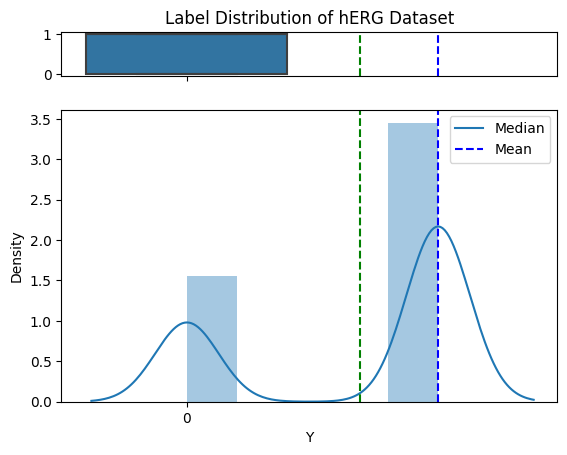

Cleaning mols: 100%|██████████| 131/131 [00:00<00:00, 381.52it/s]


Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Epoch 0: [Train] R2: 0.007, Loss: 0.641
EarlyStopping counter: 1 out of 30
Epoch 5: [Train] R2: 0.064, Loss: 0.600
EarlyStopping counter: 1 out of 30
Epoch 10: [Train] R2: 0.184, Loss: 0.558
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
Epoch 15: [Train] R2: 0.246, Loss: 0.512
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopping counter: 4 out of 30
Epoch 20: [Train] R2: 0.261, Loss: 0.476
EarlyStopping counter: 5 out of 30
EarlyStopping counter: 6 out of 30
EarlyStopping counter: 7 out of 30
EarlyStopping counter: 8 out of 30
EarlyStopping counter: 9 out of 30
Epoch 25: [Train] R2: 0.296, Loss: 0.451
EarlyStopping counter: 10 out of 30
EarlyStopping counter: 11 out of 30
EarlyStopping counter: 12 out of 30
EarlyStopping counter: 13 out of 30
EarlyStopping counter: 14 out of 30
Epoch 3

100%|██████████| 3/3 [00:00<00:00, 13.32it/s]
Downloading...


total_loss: 0.442
******************** OVERALL ********************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.817  &  0.646  &          0.808  &     0.990  &0.303  &0.890 &0.852 &   0.458 &   0.936

*************** hERG ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.817  &  0.646  &          0.808  &     0.990  &0.303  &0.890 &0.852 &   0.458 &   0.936


hERG_Karim

*************** hERG_Karim ***************


100%|██████████| 885k/885k [00:00<00:00, 2.08MiB/s]
Loading...
Done!


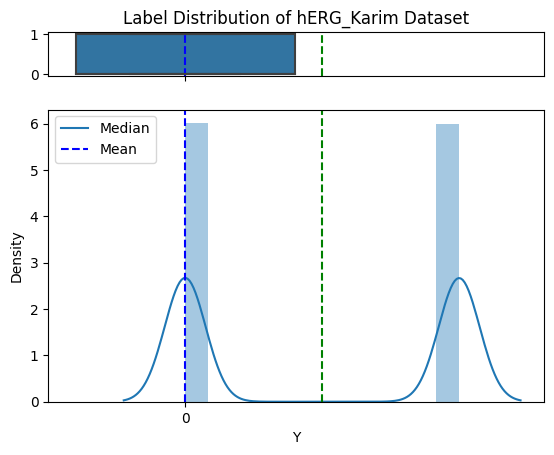

Cleaning mols: 100%|██████████| 2689/2689 [00:07<00:00, 340.50it/s]


Processing dgl graphs from scratch...
Processing molecule 1000/9412
Processing molecule 2000/9412
Processing molecule 3000/9412
Processing molecule 4000/9412
Processing molecule 5000/9412
Processing molecule 6000/9412
Processing molecule 7000/9412
Processing molecule 8000/9412
Processing molecule 9000/9412
Processing dgl graphs from scratch...
Processing molecule 1000/1344
Processing dgl graphs from scratch...
Processing molecule 1000/2689
Processing molecule 2000/2689
Epoch 0: [Train] R2: 0.004, Loss: 0.694
Epoch 5: [Train] R2: 0.135, Loss: 0.619
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
Epoch 10: [Train] R2: 0.172, Loss: 0.598
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
Epoch 15: [Train] R2: 0.185, Loss: 0.590
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch 20: [Train] R2: 0.198, Loss: 0.581
EarlyStopping counter: 1 out of 30
EarlySto

100%|██████████| 43/43 [00:02<00:00, 15.44it/s]


total_loss: 0.429
******************** OVERALL ********************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.809  &  0.809  &          0.814  &     0.800  &0.818  &0.807 &0.888 &   0.618 &   0.891

*************** hERG ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.809  &  0.809  &          0.814  &     0.800  &0.818  &0.807 &0.888 &   0.618 &   0.891



Downloading...



AMES

*************** AMES ***************


100%|██████████| 344k/344k [00:00<00:00, 1.35MiB/s]
Loading...
Done!


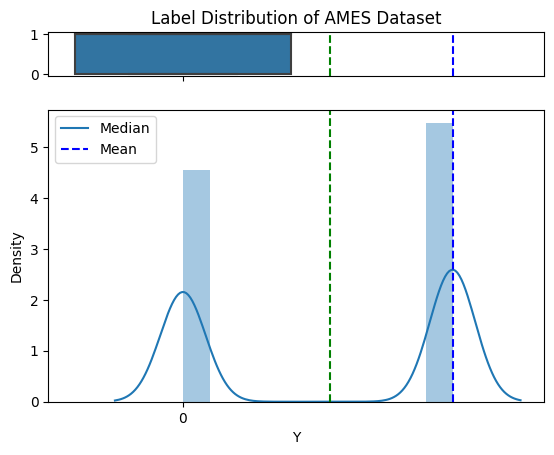

Cleaning mols: 100%|██████████| 1456/1456 [00:03<00:00, 447.69it/s]


Processing dgl graphs from scratch...
Processing molecule 1000/5094
Processing molecule 2000/5094
Processing molecule 3000/5094
Processing molecule 4000/5094
Processing molecule 5000/5094
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1456
Epoch 0: [Train] R2: 0.035, Loss: 0.672
EarlyStopping counter: 1 out of 30
Epoch 5: [Train] R2: 0.143, Loss: 0.609
EarlyStopping counter: 1 out of 30
Epoch 10: [Train] R2: 0.197, Loss: 0.574
EarlyStopping counter: 1 out of 30
Epoch 15: [Train] R2: 0.251, Loss: 0.542
EarlyStopping counter: 1 out of 30
Epoch 20: [Train] R2: 0.285, Loss: 0.523
EarlyStopping counter: 1 out of 30
Epoch 25: [Train] R2: 0.302, Loss: 0.515
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch 30: [Train] R2: 0.314, Loss: 0.507
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch 35: [Train] R2: 0.334, Loss: 0.494
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out o

100%|██████████| 23/23 [00:00<00:00, 27.99it/s]
Downloading...


total_loss: 0.439
******************** OVERALL ********************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.799  &  0.796  &          0.806  &     0.835  &0.757  &0.820 &0.879 &   0.594 &   0.893

*************** AMES ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.799  &  0.796  &          0.806  &     0.835  &0.757  &0.820 &0.879 &   0.594 &   0.893


hERG_inhib

*************** hERG_inhib ***************


100%|██████████| 23.6M/23.6M [00:01<00:00, 16.2MiB/s]
Loading...
Done!


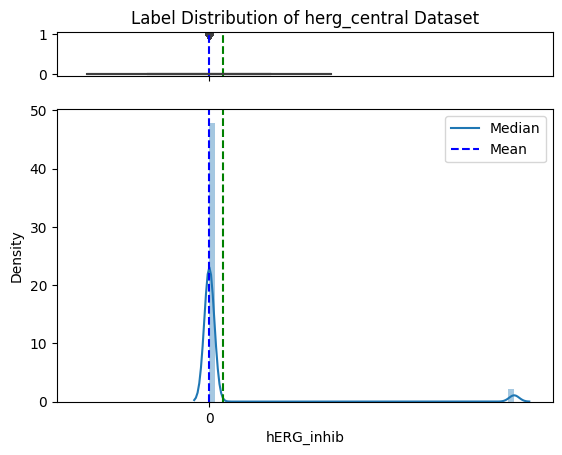

Cleaning mols: 100%|██████████| 61379/61379 [02:45<00:00, 370.64it/s]


Processing dgl graphs from scratch...
Processing molecule 1000/214825
Processing molecule 2000/214825
Processing molecule 3000/214825
Processing molecule 4000/214825
Processing molecule 5000/214825
Processing molecule 6000/214825
Processing molecule 7000/214825
Processing molecule 8000/214825
Processing molecule 9000/214825
Processing molecule 10000/214825
Processing molecule 11000/214825
Processing molecule 12000/214825
Processing molecule 13000/214825
Processing molecule 14000/214825
Processing molecule 15000/214825
Processing molecule 16000/214825
Processing molecule 17000/214825
Processing molecule 18000/214825
Processing molecule 19000/214825
Processing molecule 20000/214825
Processing molecule 21000/214825
Processing molecule 22000/214825
Processing molecule 23000/214825
Processing molecule 24000/214825
Processing molecule 25000/214825
Processing molecule 26000/214825
Processing molecule 27000/214825
Processing molecule 28000/214825
Processing molecule 29000/214825
Processing mol

KeyboardInterrupt: ignored

In [8]:
for name in ['hERG', 'hERG_Karim', 'AMES']+ [label_list[2]] :
    print()
    print(name)
    print()
    name = [name]
    single_train(name, IS_R=False)